# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [1]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [2]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.

Nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [3]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:


$$tsh \in(\,40, \,60\,)$$

$$(1) \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$

$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$

$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$

$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [1]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

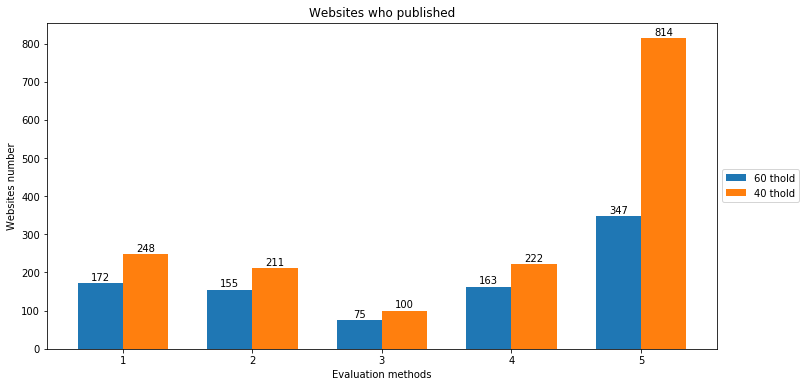

In [5]:
i = 0
generate_plot(i, stp)
plt.show()

### Percentuale siti con pubblicazioni

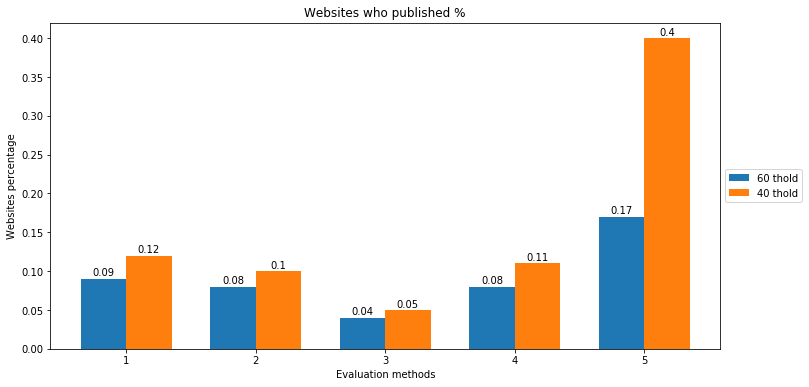

In [6]:
i = 1
generate_plot(i, stp)
plt.show()

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

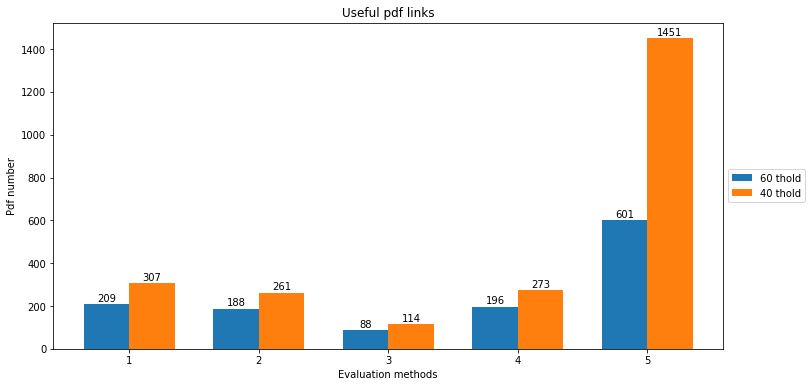

In [7]:
i = 2
generate_plot(i, stp)
plt.show()

### Percentuale di file pdf utili

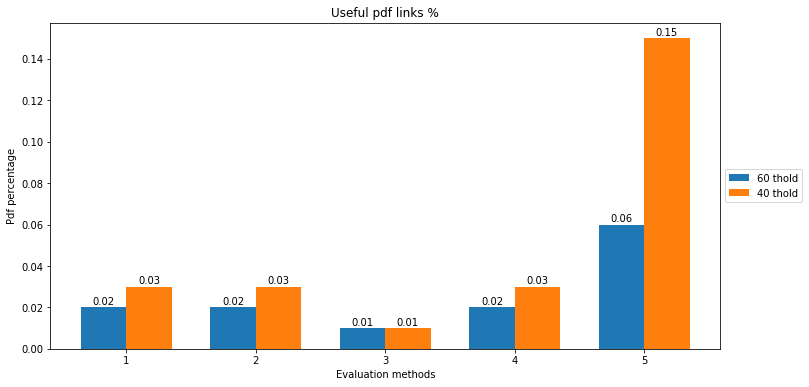

In [8]:
i = 3
generate_plot(i, stp)
plt.show()

### Profondità media dei file

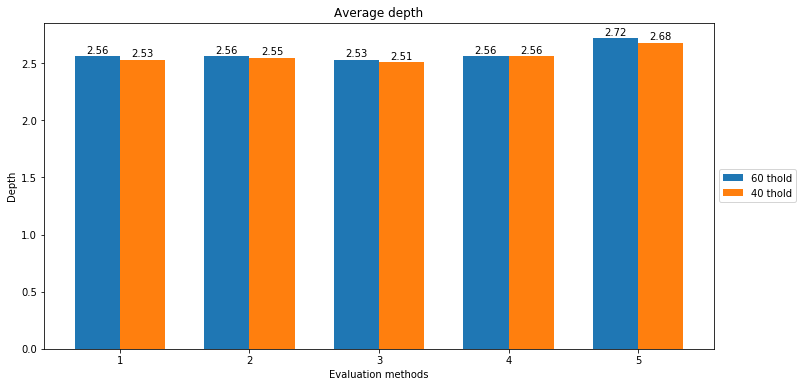

In [9]:
i = 4
generate_plot(i, stp)
plt.show()

### Numero di link presenti in homepage

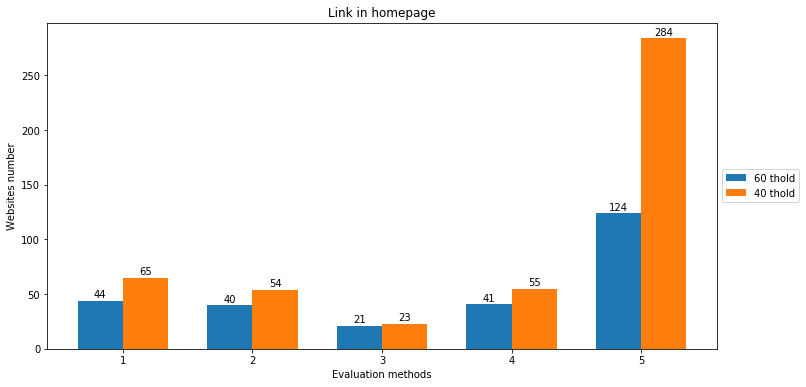

In [10]:
i = 5
generate_plot(i, stp)
plt.show()

# File processing

Dopo aver ottenuto la lista di link ( è stata utilizzata la lista ottenuta dalla prima condizione tra quelle testate, essendo quella che tiene in considerazione più file ) i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili.

In [11]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,307
1,file to process,239
2,file processed,218


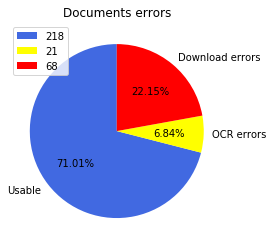

In [12]:
labels = 'Usable', 'OCR errors', 'Download errors'
val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'r']

fig1, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
ax.set_title("Documents errors")
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

## Statistiche popolazione

La popolazione dell'indice si basa su richieste alle API Atoka e Dandelion.
È possibile che alcuni report siano stati pubblicati da aziende le cui informazioni non sono completamente reperibili tramite Atoka, ci sono quindi alcuni documenti elastic incompleti, che presentano ad esempio la mancanza dell'indirizzo dell'azienda, del codice ateco, dei ricavi o del numero di dipendenti.

Companies in index: 170


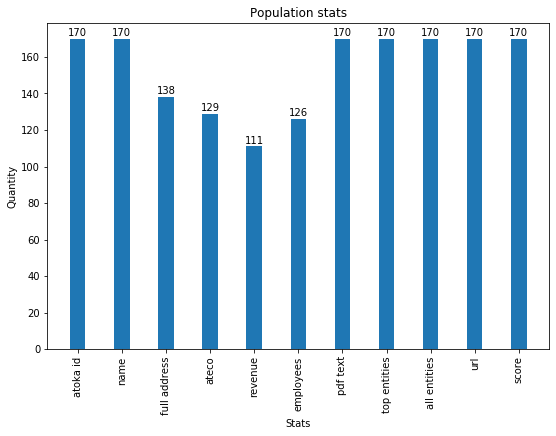

In [13]:
from elasticsearch_utilities import generate_plot

stats_path = "elasticsearch_utilities/stats/population.csv"
generate_plot(stats_path)
print("Companies in index: 170")
plt.show()

# Analisi: Latent Dirichlet Allocation

Per meglio capire gli argomenti trattati nei bilanci è stato usato un modello Latent Dirichlet Allocation.
L'insieme di parole per ogni documento è stato ottenuto dalle entità estratte con Dandelion, esse sono poi state tradotte in inglese poichè i documenti scaricati presentavano lingue differenti.

I modelli sono stati creati provando a considerare sia tutte le entità, che quelle principali.

# Modelli su tutte le entità

Il numero di entità presente per ogni documento è abbastanza alto, in media sono presenti __2496__ entità.

È stato creato un modello con l'insieme completo di entità, senza alcun vincolo, poi sono stati considerati dei vincoli di frequenza tra documenti e all'interno di un singolo documento.

## Modello senza vincoli di frequenza - entità complete

Il primo modello non presenta vicoli sulle keyword, si cercano quindi i topics considerando la lista completa di entità estratte dal testo.

### Preprocessing
Il primo passo sta nella preprocessazione dei dati: si parte dalla lista di entità per ogni documento, e si arriva alle strutture necessarie ad allenare il modello, ovvero:
1. _dtm_tf_ : frequency vector
2. _tf_vectorizer_ : count vectorizer contentente il vocabolario estratto dai documenti

In [14]:
csv_input = "elasticsearch_utilities/stats/input_all_entities_en.csv"

data = pd.read_csv(csv_input)
data.head()

,elastic_index,entities
0,1,Secret_Intelligence_Service no Open_Systems_In...
1,2,Sustainability History Scientific_research Sus...
2,3,Board_of_Directors economy Quality_of_life Com...
3,4,Rosia_Montana Value_added Recycling circular_E...
4,5,Financial_statements Product_(economics) Work ...


L'input è preprocessato ottenendo le strutture utili a creare successivamente il modello.

In [2]:
from lda_topic_model import preprocess, print_vocab

dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_all_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 24646 

Words:

'secret_intelligence_service' : 19536
'open_systems_interconnection' : 15581
'galactic_standard_calendar' : 8997
'autonomous_province_of_trento' : 2103
'natural_resource' : 14809
'gender_' : 9138
'social_sciences' : 20243
'technology' : 21568
'vita' : 23724
'environment_' : 7377
...


### Creazione modello

Il modello viene creato partendo dai dati preprocessati, ovvero dalle entità trovate per ogni documento.

Lo scopo è quello di capire di cosa si parla nella raccola di documenti, andando a trovare degli argomenti formati dalle parole presenti in ogni documento.

### Parametri 
Nella creazione del modello bisogna tenere conto del numero di argomenti da trovare e di due parametri alpha e beta.

I valori di __alpha__ e __beta__ controllano rispettivamente:
1. quanti topics fanno parte di un documento: per un valore basso si assume che ogni documento sia composto da pochi topics 
2. quante parole compongono ogni topic: un valore più basso fa assumere al modello che ogni topic sia composto da poche keyword specifiche.
    
Per tutti i modelli che seguono, i parametri __topics__,  __alpha__ e __beta__ sono stati impostati per avere la maggior divisione e chiarezza possibile nella presentazione della distribuzione degli argomenti nei documenti.

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

topics = 20
alpha = 0.13
beta =  0.07

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.287471 -0.081663       1        1  20.103703
13    -0.216667  0.056953       2        1  13.264650
7     -0.264114 -0.092605       3        1  13.154569
2      0.074433 -0.180482       4        1  10.198821
1     -0.229744 -0.020346       5        1   9.763840
0     -0.210351  0.012550       6        1   5.460112
14     0.166124 -0.138448       7        1   3.866569
12     0.104412 -0.148801       8        1   3.637537
18    -0.189495  0.085180       9        1   3.633948
15     0.110892 -0.108180      10        1   3.168361
4      0.167037 -0.116739      11        1   3.112852
8      0.019827  0.011901      12        1   2.419972
9      0.116660  0.021717      13        1   2.005280
17     0.076385  0.058677      14        1   1.371108
3     -0.107087  0.113911      15        1   1.207260
10     0.121756  0.004367      16        1   1.050607
5      0.176647  0.031240      17        1   0.990480
6      0.124557  0.184154      18        1   0.631534
16     0.103514  0.148355      19        1   0.511359
19     0.142683  0.158259      20        1   0.447438, topic_info=                      Term         Freq        Total Category  logprob  \
10126               henkel  2940.000000  2940.000000  Default  30.0000   
7198            employment  7721.000000  7721.000000  Default  29.0000   
8278               finance  3406.000000  3406.000000  Default  28.0000   
7619                  euro  2508.000000  2508.000000  Default  27.0000   
21193       sustainability  9405.000000  9405.000000  Default  26.0000   
...                    ...          ...          ...      ...      ...   
17597  province_of_brescia     6.957813    42.905955  Topic20  -5.6886   
18191            recycling     8.722875  1097.805649  Topic20  -5.4625   
2725               biomass     7.128861    92.235124  Topic20  -5.6643   
4435                 city_     7.276429   183.110609  Topic20  -5.6438   
4829                common     7.299405   630.823602  Topic20  -5.6407   

       loglift  
10126  30.0000  
7198   29.0000  
8278   28.0000  
7619   27.0000  
21193  26.0000  
...        ...  
17597   3.5902  
18191   0.5743  
2725    2.8492  
4435    2.1839  
4829    0.9502  

[1372 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
41         3  0.015985                 18p
41         5  0.015985                 18p
41         6  0.015985                 18p
41         9  0.927135                 18p
41        15  0.015985                 18p
...      ...       ...                 ...
24472     14  0.762495                yarn
24572      2  0.994941             zermelo
24584      2  0.992076  zf_friedrichshafen
24584      7  0.004614  zf_friedrichshafen
24603     11  0.991778               zogno

[4186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 14, 8, 3, 2, 1, 15, 13, 19, 16, 5, 9, 10, 18, 4, 11, 6, 7, 17, 20])

## Modello con vincoli di frequenza - entità complete

Per il modello che segue sono stati impostati dei vincoli di frequenza, un' entità viene considerata a patto che:
1. compaia in almeno __N__ documenti distinti
2. compaia almeno __M__ volte all'interno di un documento

L'obiettivo è quello di scartare quei termini strettamente legati al settore spefico della singola azienda autrice del bilancio e quei termini secondari all'interno di un documento.

### Grandezza vocabolario

A seguire la grandezza del vocabolario in relazione ai valori __N__ ed __M__.

Tenendo presente che:
- il __totale__ dei __documenti__ è di __170__.
- il numero __medio__ di __entità__ trovate in un testo è di __2496__

si può notare che anche valori molto piccoli di N ed M riducono di molto la grandezza del vocabolario.

Il grafico non presenta l'andamento completo, ma solo la parte iniziale in cui si nota un decremento esponenziale della dimensione.

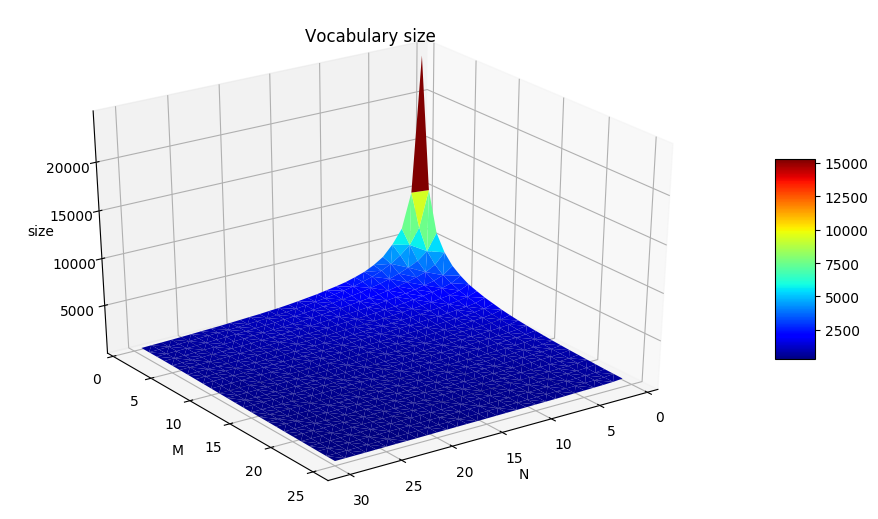

In [3]:
from lda_topic_model import generate_plot

stats_path = "lda_topic_model/data/vocabulary_stats_all_entities.csv"
generate_plot(stats_path)
plt.show()

### Modello

Il procedimento è lo stesso mostrato per il modello precedente, cambia la funzione di preprocessing che implementa le __restrizioni__ discusse sopra.

Avendo una restrizione sulla frequenza, è opportuno cambiare i parametri del modello, in particolare, si cercano __meno topics__, poichè con il vincolo di frequenza si eliminano gli argomenti troppo specifici per ogni documento. Come conseguenza sono cambiati opportunamente anche i parametri alpha e beta, coem discusso in precedenza.

A seguire il modello che considera solo i termini presenti in almeno il __25%__ dei __documenti__ e presenti almeno __15__ volte all'interno di un singolo documento.

In [52]:
from lda_topic_model import preprocess_freq_count

N = round(170 * 0.25)
M = 15

dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_all_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 11
alpha = 0.1
beta = 0.1
lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 296 

Words:

'environment_' : 82
'biology' : 11
'scientific_research' : 230
'sustainability' : 261
'sustainable_development' : 262
'stakeholder' : 252
'quality' : 202
'safety' : 223
'homo_sapiens' : 120
'innovation' : 133
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.227490  0.052737       1        1  21.636659
5      0.280890  0.050914       2        1  17.395737
6      0.230915 -0.010871       3        1  17.225212
1      0.176041 -0.229635       4        1  11.698748
4     -0.186495  0.084534       5        1  10.447847
3      0.206252  0.144592       6        1   5.689818
0     -0.115445 -0.244347       7        1   4.239788
9     -0.277660  0.095218       8        1   3.946020
2     -0.168558  0.019181       9        1   3.086522
8     -0.217695 -0.159939      10        1   2.939224
10    -0.155735  0.197614      11        1   1.694424, topic_info=                          Term         Freq        Total Category  logprob  \
89                        euro  2357.000000  2357.000000  Default  30.0000   
261             sustainability  9371.000000  9371.000000  Default  29.0000   
78                  employment  7653.000000  7653.000000  Default  28.0000   
292                       work  2030.000000  2030.000000  Default  27.0000   
82                environment_  1741.000000  1741.000000  Default  26.0000   
..                         ...          ...          ...      ...      ...   
261             sustainability   161.147163  9371.769655  Topic11  -2.7283   
66                   economics    38.158287  2818.286390  Topic11  -4.1689   
266                 technology    20.548449  2057.180259  Topic11  -4.7878   
83   environmental_engineering     0.098593    15.839015  Topic11 -10.1274   
131                information     3.604460  1805.724975  Topic11  -6.5284   

     loglift  
89   30.0000  
261  29.0000  
78   28.0000  
292  27.0000  
82   26.0000  
..       ...  
261   0.0147  
66   -0.2243  
266  -0.5285  
83   -1.0014  
131  -2.1387  

[533 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         4  0.921699     accounting
0        11  0.076505     accounting
1         7  0.949339         africa
2         8  0.997593    agriculture
3         1  0.420574  air_pollution
...     ...       ...            ...
292      11  0.161083           work
293       3  0.172513      workforce
293       6  0.811825      workforce
294       3  0.982833   working_time
295       9  0.980012          world

[898 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 7, 2, 5, 4, 1, 10, 3, 9, 11])

# Modelli liste di entità principali

I modelli che seguono sono creati e visualizzati seguendo lo stesso procedimento mostrato sopra, utilizzano però la lista di __entità principali__.

La lista di entità questa volta non contiene doppioni, si può pensare alle entità principali come a un set ordinato per importanza, cambierà quindi il criterio di frequenza, essendo il precedente inapplicabile nella parte di conteggio delle occorrenze all'interno di ogni documento.  

Lo scopo è quello di isolare i termini ritenuti secondari e dunque ricavare dei __modelli__ più __specifici__.

Anche in questo caso è inizialmente considerato l'insieme totale di entità e successivamente quello ristretto per il nuovo criterio di frequenza, che questa volta non considererà il vincolo intra-documento.

## Modello senza vincoli di frequenza - entità principali

Il vocabolario è più ristretto rispetto al modello che considera tutte le entità del testo, è grande meno della metà. Bisogna però tenere presente che il numero medio di entità principali per ogni testo è di 250, molto minore di 2496, media del numero di entità complete.

In [33]:
dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_top_entities_en.csv")
print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 10271 

Words:

'secret_intelligence_service' : 8168
'open_systems_interconnection' : 6405
'galactic_standard_calendar' : 3686
'autonomous_province_of_trento' : 785
'natural_resource' : 6082
'gender_' : 3744
'social_sciences' : 8462
'technology' : 9039
'vita' : 9899
'environment_' : 2973
...


Per la scelta dei parametri nel modello, si è __ridotto__ il numero di __topics__, sistemando quindi alpha e beta.

In [35]:
topics = 15
alpha = 0.01
beta =  0.07

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.004325  0.237944       1        1  29.569090
13    -0.258731 -0.006339       2        1  21.649296
11    -0.218393 -0.011910       3        1  10.034948
7     -0.176904 -0.053193       4        1   8.357081
2      0.051081  0.177878       5        1   6.872305
12    -0.157511 -0.036713       6        1   5.638843
6      0.089111  0.095129       7        1   3.454473
1      0.090323  0.064302       8        1   3.122253
5     -0.040517 -0.089598       9        1   2.922327
9      0.084338  0.039931      10        1   2.358178
8      0.073393  0.000324      11        1   2.062370
10     0.113582 -0.123910      12        1   1.527042
3      0.124540 -0.103270      13        1   1.041339
4      0.108084 -0.099260      14        1   0.865839
0      0.121929 -0.091315      15        1   0.524618, topic_info=                              Term        Freq       Total Category  logprob  \
7796                         right  170.000000  170.000000  Default  30.0000   
3356                       finance  220.000000  220.000000  Default  29.0000   
1245                      business  283.000000  283.000000  Default  28.0000   
2722                     economics  395.000000  395.000000  Default  27.0000   
1018                       biology   94.000000   94.000000  Default  26.0000   
...                            ...         ...         ...      ...      ...   
7725                   resignation    0.269367    1.540410  Topic15  -6.8029   
8260            sexual_intercourse    0.269367    2.416728  Topic15  -6.8029   
2766                      election    0.269367    1.606348  Topic15  -6.8029   
4608  international_criminal_court    0.269367    1.895794  Topic15  -6.8029   
8788                       stress_    0.269367    3.990070  Topic15  -6.8029   

      loglift  
7796  30.0000  
3356  29.0000  
1245  28.0000  
2722  27.0000  
1018  26.0000  
...       ...  
7725   3.5065  
8260   3.0562  
2766   3.4646  
4608   3.2989  
8788   2.5548  

[1706 rows x 6 columns], token_table=       Topic      Freq                      Term
term                                            
20         9  0.505589                        20
50        12  0.847718                       4sd
65        12  0.847718                  9k33_osa
74        10  0.775997               _cittadella
77        10  0.775997                _de_meuron
...      ...       ...                       ...
10142      9  0.044076                 workforce
10160      2  0.692282  world_energy_consumption
10160      3  0.122167  world_energy_consumption
10160      4  0.162890  world_energy_consumption
10209      9  0.505589               yes_yes_yes

[2928 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 12, 8, 3, 13, 7, 2, 6, 10, 9, 11, 4, 5, 1])

## Modello con vincoli di frequenza - entità principali

Il criterio per il vincolo di frequenza cambia: 
1. __N__ rimane lo stesso, ovvero specifica la __frequenza inter-documento__ di un' entità.
2. __M__ questa volta diventa la __quantità__ di __entità considerate__ per ogni documento. Un paramentro piccolo indicherà la considerazione delle parole più importanti, mentre un paramentro alto comprenderà una quantità di parole, meno importanti, più elevata.

Per quanto riguarda la restrizione di frequenza inter-documento, ovvero sul parametro N, l'andamento della curva decresce in modo esponenziale, in linea con la curva nell'esempio precedente.

Per quanto riguarda il paramentro M, questa volta porta ad un incremento lineare del vocabolario, poichè ad ogni step si include un numero di entità proporzionale al totale dei documenti.

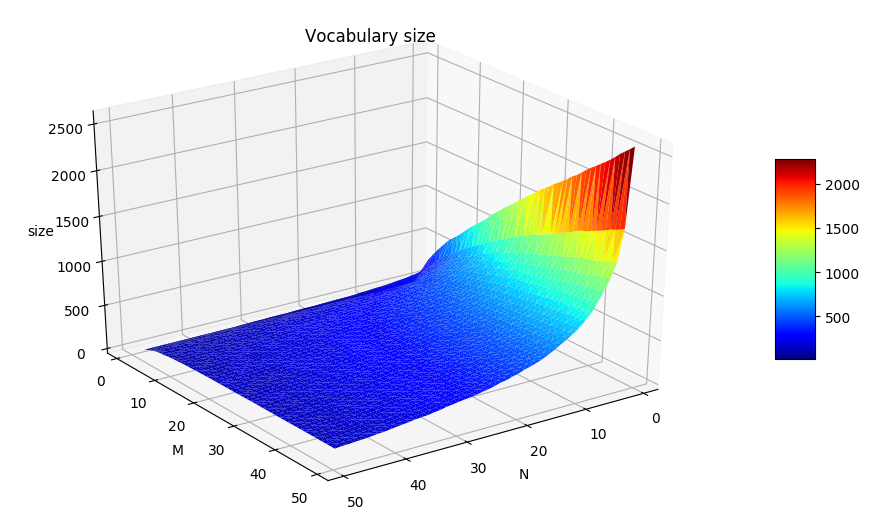

In [5]:
stats_path = "lda_topic_model/data/vocabulary_stats_top_entities.csv"
generate_plot(stats_path, en="top")
plt.show()

Il modelli che seguono mantengono la restrizione della frequenza adottata in precedenza per quanto riguarda N, ovvero si considerano i termini presenti nel __25%__ dei __documenti__, mentre per __M__ si usano __50__ e __30__ rispettivamente.

### M = 50

In [11]:
from lda_topic_model import preprocess_freq_count_relevant

topics = 10
alpha = 0.7
beta = 0.1

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)

N = round(170 * 0.25)
M = 50

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 175 

Words:

'natural_resource' : 99
'technology' : 156
'environment_' : 47
'biology' : 6
'territory' : 157
'water' : 169
'economical_progress' : 38
'policy' : 109
'work' : 172
'management' : 88
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.180905  0.003500       1        1  16.607195
8     -0.221558 -0.009887       2        1  16.471672
7     -0.188021 -0.119767       3        1  12.533375
0     -0.218130 -0.055435       4        1  10.405208
4      0.050879 -0.084828       5        1  10.154585
6     -0.201775  0.058801       6        1   9.397863
5      0.230780 -0.031025       7        1   8.426559
3      0.119281  0.011851       8        1   5.891031
2      0.237347 -0.078579       9        1   5.448268
9      0.010292  0.305369      10        1   4.664244, topic_info=                  Term       Freq      Total Category  logprob  loglift
52                euro  45.000000  45.000000  Default  30.0000  30.0000
27         corporation  56.000000  56.000000  Default  29.0000  29.0000
40             economy  74.000000  74.000000  Default  28.0000  28.0000
29             culture  44.000000  44.000000  Default  27.0000  27.0000
163          transport  27.000000  27.000000  Default  26.0000  26.0000
..                 ...        ...        ...      ...      ...      ...
95         methodology   0.139148  14.586888  Topic10  -7.2517  -1.5871
119       raw_material   0.139147  28.527294  Topic10  -7.2517  -2.2578
14               child   0.139144   8.233778  Topic10  -7.2517  -1.0152
135  scientific_method   0.139143  14.535106  Topic10  -7.2517  -1.5836
71        human_rights   0.139142  23.992694  Topic10  -7.2518  -2.0848

[424 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         4  0.818533     accounting
1         7  0.933725    agriculture
2         3  0.954227  air_pollution
3         2  0.941200          audit
4         1  0.196726       behavior
...     ...       ...            ...
172       9  0.133300           work
173       2  0.903440      workforce
174       1  0.218189          world
174       4  0.327284          world
174       5  0.436378          world

[509 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 8, 1, 5, 7, 6, 4, 3, 10])

### M = 30

In [39]:
topics = 12
alpha = 0.4
beta = 0.4
lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)

N = round(170 * 0.25)
M = 30

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 174 

Words:

'natural_resource' : 99
'technology' : 156
'environment_' : 47
'biology' : 6
'territory' : 157
'water' : 168
'economical_progress' : 38
'policy' : 109
'work' : 171
'management' : 88
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.135449 -0.067864       1        1  27.911020
8      0.152443 -0.073337       2        1  20.361961
9      0.178498  0.003163       3        1  12.177035
10    -0.122573 -0.116594       4        1   7.079855
2      0.088564 -0.057959       5        1   6.259202
11    -0.078944  0.019690       6        1   5.351922
5     -0.065632  0.006720       7        1   4.179907
3      0.089808  0.020484       8        1   4.091676
4     -0.048962  0.072676       9        1   3.911852
0     -0.015708  0.101274      10        1   3.663616
7     -0.034887  0.063953      11        1   3.105965
1     -0.007158  0.027794      12        1   1.905988, topic_info=             Term       Freq      Total Category  logprob  loglift
8        business  62.000000  62.000000  Default  30.0000  30.0000
165        value_  36.000000  36.000000  Default  29.0000  29.0000
29        culture  20.000000  20.000000  Default  28.0000  28.0000
75     innovation  32.000000  32.000000  Default  27.0000  27.0000
47   environment_  47.000000  47.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
27    corporation   0.298623  28.309415  Topic12  -5.1601  -0.5916
74    information   0.298522  26.141362  Topic12  -5.1604  -0.5123
109        policy   0.298416  19.730544  Topic12  -5.1608  -0.2313
162      training   0.298403  21.393545  Topic12  -5.1608  -0.3122
171          work   0.298372  36.716856  Topic12  -5.1609  -0.8525

[524 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.193473   accounting
0         2  0.193473   accounting
1         2  0.366353  agriculture
1         3  0.122118  agriculture
1        10  0.122118  agriculture
...     ...       ...          ...
171       5  0.136177         work
172       6  0.337376    workforce
173       1  0.252733        world
173       3  0.379099        world
173       8  0.126366        world

[523 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 10, 11, 3, 12, 6, 4, 5, 1, 8, 2])